In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np # For np.nan and general numerical operations
import geopandas
from shapely.geometry import Point

In [2]:
# Load the CSV data
df = pd.read_csv("grow_attributes.csv", delimiter=';', low_memory=False)

In [3]:
# Extract starting and ending years for time-based analysis
df['starting_year'] = pd.to_datetime(df['starting_date']).dt.year
df['ending_year'] = pd.to_datetime(df['ending_date']).dt.year

In [4]:
# Define filter criteria for later use
df['over_30_years'] = df['length_years'] >= 30
df['gap_free'] = df['gap_fraction'] == 0.0
df['monthly'] = df['interval'] == 'MS'
df['ends_2023_or_later'] = df['ending_year'] >= 2023

In [5]:
# Define the path to your downloaded world map shapefile
# IMPORTANT: Replace this with the actual path to your 'ne_110m_admin_0_countries.shp' file
# Example: r"C:\\Users\\YourUser\\Downloads\\ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp"
world_map_filepath = r"C:\\Users\\tarik\\Desktop\\Maps" # Ensure this points directly to the .shp file

In [6]:
# Ensure ending_date is a datetime object in the DataFrame 'df'
df["ending_date"] = pd.to_datetime(df["ending_date"])

In [7]:
print("Libraries loaded and data initialized.")

Libraries loaded and data initialized.


In [8]:
# Filter only the monitoring stations in Czech Republic with the desired criteria
attr_filtered_df = df[
    (df["country"] == "CZE") &
    (df["length_years"] >= 30) &
    (df["gap_fraction"] == 0.0) &
    (df["ending_date"] >= pd.Timestamp("2023-12-01"))
].copy()

In [9]:
if attr_filtered_df.empty:
    raise ValueError("No filtered monitoring stations found in Czech Republic (CZE).")

In [10]:
print(f"Number of filtered monitoring stations in the Czech Republic: {len(attr_filtered_df)}")

Number of filtered monitoring stations in the Czech Republic: 264


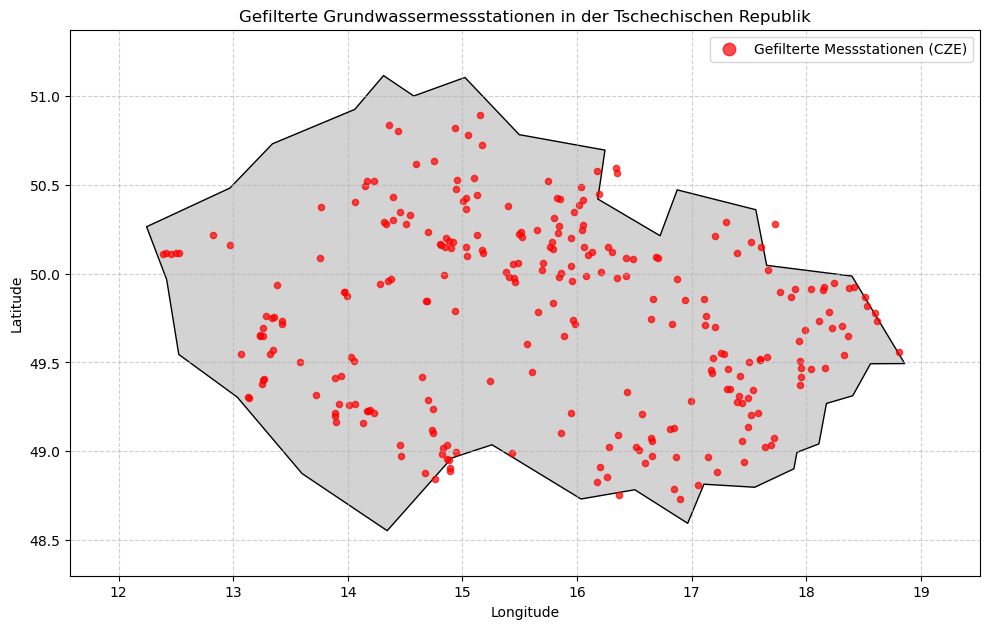

In [11]:
# Check if coordinates exist
if {'latitude', 'longitude'}.issubset(attr_filtered_df.columns):
    # Create GeoDataFrame
    geometry = [Point(xy) for xy in zip(attr_filtered_df['longitude'], attr_filtered_df['latitude'])]
    gdf_filtered = geopandas.GeoDataFrame(attr_filtered_df, geometry=geometry, crs="EPSG:4326")

    # Try to load the background map
    try:
        world = geopandas.read_file(world_map_filepath)
        cz_boundary = world[world['ADM0_A3'] == 'CZE']
        if cz_boundary.empty:
            print("Czech Republic boundary not found. Plotting without background.")
            cz_boundary = None
    except Exception as e:
        print(f"Error loading map: {e}")
        cz_boundary = None

    # Plot
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    if cz_boundary is not None:
        cz_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')

    gdf_filtered.plot(
        ax=ax,
        marker='o',
        color='red',
        markersize=20,
        alpha=0.7,
        label='Gefilterte Messstationen (CZE)'
    )

    ax.set_title("Gefilterte Grundwassermessstationen in der Tschechischen Republik")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Set map boundaries to country borders (with padding)
    if cz_boundary is not None and not cz_boundary.empty:
        minx, miny, maxx, maxy = cz_boundary.total_bounds
        padding_x = (maxx - minx) * 0.1
        padding_y = (maxy - miny) * 0.1
        ax.set_xlim(minx - padding_x, maxx + padding_x)
        ax.set_ylim(miny - padding_y, maxy + padding_y)
    else:
        ax.set_xlim(12.0, 19.0)
        ax.set_ylim(48.5, 51.5)

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(markerscale=2)
    plt.tight_layout()
    plt.show()
else:
    print("Spalten 'latitude' und 'longitude' fehlen – keine Kartenanzeige möglich.")